In [1]:
#common packages we basically always need
import numpy as np
import matplotlib.pyplot as plt
import time

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Wed Oct 18 19:00:09 2017', '__version__': '1.0', '__globals__': [], 'testX': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), 'testY': array([[7, 2, 1, ..., 4, 5, 6]], dtype=uint8), 'trainY': array([[5, 0, 4, ..., 5, 6, 8]], dtype=uint8), 'trainX': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}


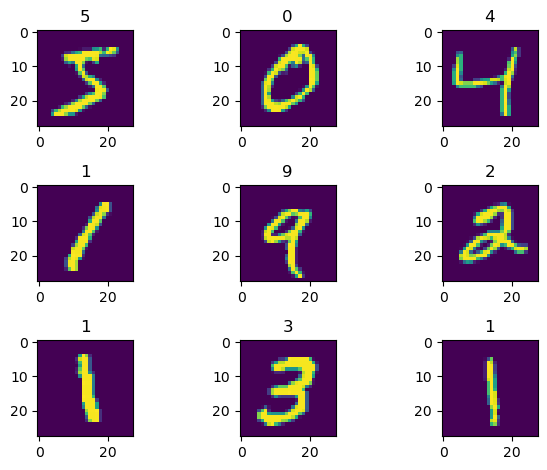

In [2]:
#load the MNIST dataset with binary pixel values
import scipy.io as sio
data = sio.loadmat('mnist.mat')
print(data)



Xtrain, Xtest = data['trainX'].astype(float), data['testX'].astype(float)
ytrain, ytest = data['trainY'][0], data['testY'][0]

#pull and plot some samples
for k in range(9):
    plot_data = Xtrain[k,:]
    plot_data = np.reshape(plot_data,(28,28))
    plot_label = ytrain[k]
    plt.subplot(3,3,k+1)
    plt.imshow(plot_data)
    plt.title(plot_label)
plt.tight_layout()

def get_small_dataset(X,y,m):
    return X[:m,:],y[:m]

num_labels = len(np.unique(ytrain))
num_feats = Xtrain.shape[1]

In [3]:
def get_dist(Xtrain,zquery):
    #initialize empty array
    #iterate through the 60000 subarrays in Xtrain
    #for each subarray, subtract zquery from it, then square the difference, then sum elements to get single value
    #subtracting ndarrays is actually super intuitive, it subtracts corresponding elements to retain vector dimensions
    returnArray = []
    for innerArray in Xtrain:
        returnArray.append(np.sum(np.square(innerArray - zquery)))
    return returnArray

#right values? idk lol
#0.0
#6069462.0
#5661744.0

print(get_dist(Xtrain,Xtrain[0,:])[0])
print(get_dist(Xtrain,Xtest[0,:])[10])
print(get_dist(Xtrain,Xtest[10,:])[50])


0.0
6069462.0
5661744.0


In [4]:
import scipy.stats as ss

m = 100
K = 3

Xtrain_small, ytrain_small = get_small_dataset(Xtrain,ytrain,m)

def pred(zquery,Xtrain,ytrain, K):
    #zquery is a 1-d vector, the testing point. In this case, its vector size is 784
    #Xtrain is a 2-d vector, containing the training data. In this case, it has 100 vectors of size 784
    #ytrain is a 1-d vector, containing the labels of the data in Xtrain .In this case, its vector size is 100 and all the elements are the number 5
    #K is the number of closest neighbors to look at
    
    distArray = get_dist(Xtrain, zquery)
    distArray = np.array(distArray)  #i think this can be removed? it gives access to numpy array functions
    #distArray is a 1d array holding all distances between each vector from Xtrain and zquery
    
    #get the index place of the valuye from ss.mode
    #connect it to its label
    #return its label
    neighborsLabel = []
    
    for neighborNum in range(K):
        
        #modeValue = ss.mode(distArray)[0][0]
        nearestNeighborValue = np.amin(distArray)
        nearestNeighborIndex = np.where(distArray==nearestNeighborValue)
        #distArray.remove(nearestNeighborValue)
        distArray = np.delete(distArray, nearestNeighborIndex)
        neighborsLabel.append(ytrain[nearestNeighborIndex])
        ytrain = np.delete(ytrain, nearestNeighborIndex)
    
    #now i possess the the nearest k neighbors, where k is a preset number of neighbors to retrieve
    #now i need to determine which to return
    #if there is only 1 neighbor, return that
    #else if the majority neighbor is only 1, then the labels are just >1 different labels so get average rounded to int
    #else if there is a clear majority, return that majority
    
    #leftmost is closest
    #print("neighbors: ",neighborsLabel)
    if (len(neighborsLabel) == 1):
        #print("selected singley: ",neighborsLabel[0])
        return neighborsLabel[0]
    else:
        modeNeighborsObject = ss.mode(neighborsLabel)
        if (modeNeighborsObject[1][0] == 1):
            #print("selected leftmost: ", (neighborsLabel[0]))
            return neighborsLabel[0]
        else:
            #print("selected most: ",modeNeighborsObject[0][0])
            return modeNeighborsObject[0][0]
        
ytest_pred = ytest + 0    
for k in range(Xtest.shape[0]):
    z = Xtest[k,:]
    ytest_pred[k] = pred(z,Xtrain_small, ytrain_small, K)
    
print(ytest_pred[:20])
print(ytest[:20])

[7 2 1 0 4 1 9 4 6 9 0 9 9 0 1 9 7 7 3 4]
[7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]


In [5]:
def get_accuracy(ytest, ypred):
    #the ratio of the number of correct predictions to the total number of input samples
    accuCount = 0
    for i in range(len(ytest)):
        if (ytest[i] == ypred[i]):
            accuCount = accuCount + 1

        
    return accuCount / len(ytest)

get_accuracy(ytest,ytest_pred)

0.6694

In [ ]:
import time
for m in [100,1000, 2500]:
    Xtrain_small, ytrain_small = get_small_dataset(Xtrain,ytrain,m)
    for K in [1,3,5]:
        
        start = time.time()
        ytest_pred = ytest + 0    
        for k in range(Xtest.shape[0]):
            z = Xtest[k,:]
            ytest_pred[k] = pred(z,Xtrain_small, ytrain_small, K)
    
        print(m,K,get_accuracy(ytest,ytest_pred), time.time()-start)

100 1 0.6794 10.769020795822144
100 3 0.6694 12.489173650741577
100 5 0.6267 13.059937000274658
1000 1 0.869 105.50663352012634
1000 3 0.872 108.56575012207031
1000 5 0.8585 107.66077542304993
2500 1 0.9136 261.1103050708771
